* Authors: Andrea Jiménez Zuñiga e Isabel Afán de Ribera
* Date: 04/12/2020
* Institution: CUNEF

# 09. Best Model 

## Import Libraries


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler  
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest # outliers
import random 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC  
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
import itertools
import pickle
from sklearn import metrics 
random.seed(12345)

## Import Data


In [12]:
loans = pd.read_csv('/Users/Andy/Desktop/CUNEF/MACHINE LEARNIG/Prestamos/data/Loan_training_set_1_4.csv', header=1, skipfooter=2)


<ipython-input-12-4ff098601adb>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  loans = pd.read_csv('/Users/Andy/Desktop/CUNEF/MACHINE LEARNIG/Prestamos/data/Loan_training_set_1_4.csv', header=1, skipfooter=2)


## Data Cleaning

Bearing in mind the large number of variables we have in our analysis (151), we are going to analyse the null values to see if we can dispense with some columns.

In [13]:
# percentage of missing values in each column
round(loans.isnull().sum()/len(loans.index), 2)*100

id                         0.0
member_id                100.0
loan_amnt                  0.0
funded_amnt                0.0
funded_amnt_inv            0.0
                         ...  
settlement_status        100.0
settlement_date          100.0
settlement_amount        100.0
settlement_percentage    100.0
settlement_term          100.0
Length: 151, dtype: float64

We can see that many columns have very high percentages of missing values. First, let's get rid of the columns having 90% missing values.

In [14]:
missing_columns = loans.columns[100*(loans.isnull().sum()/len(loans.index)) > 90]
print(missing_columns)

Index(['member_id', 'desc', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlem

All these columns with a high percentage of lost values are not of interest in our analysis since many of them are explained by other variables and others we conclude, due to business knowledge, that they do not provide information to our decision to grant or not the requested credit.

In [15]:
loans = loans.drop(missing_columns, axis=1)
print(loans.shape)

(105451, 113)


In [16]:
100 * (loans.isnull().sum() / len(loans.index))

id                            0.0
loan_amnt                     0.0
funded_amnt                   0.0
funded_amnt_inv               0.0
term                          0.0
                             ... 
total_bc_limit                0.0
total_il_high_credit_limit    0.0
hardship_flag                 0.0
disbursement_method           0.0
debt_settlement_flag          0.0
Length: 113, dtype: float64

Dropping columns that are not required, such as: url, desc, title, zip_code and id.

In [17]:
loans.drop(['url','title','zip_code','id'], axis=1, inplace=True)
loans.shape

(105451, 109)

## Choosing Variables

As the new dataset has 884,876 observations and 113 variables, we have chosen some of the most relevant variables that we have considered by studying the variables and researching. As a result, we have chosen 25 primary variables to continue with the analysis, which 19 of them are numeric and 6 are categorical variables.

These variables are:

1. `loan_amnt`: Loan amounts
2. `emp_length`: Length the borrowers have been employed.
3. `home_ownership`: Type of home ownership.
4. `annual_inc`: Annual income of each borrower.
5. `funded_amnt_inv`: Total amount commited by investors for that loan at that point of time.
6. `int_rate`: Interest rate.
7. `dti`: Debt to income ratio.
8. `installment`: Installment amount, which is tha monthly payment by the borrower if the loan originates.
9. `revol_bal`: Total Credit Revolving Balance.
10. `revol_util`: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
11. `total_acc`: Number of total accounts.
12. `open_acc`: The number of open credit lines in the borrower's credit file.
13. `funded_amnt`: The total amount committed to that loan at that point in time.
14. `last_pymnt_amnt`: Last payment amount.
15. `term`: Term, which is the duration of the loan.
16. `grade`: Credit grades.
17. `loan_status`: Loan status
18. `purpose`: A category provided by the borrower for the loan request. 
19. `sub_grade`: LC assigned loan subgrade.
20. `pub_rec`: Number of derogatory public records.
21. `inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries).
22. `delinq_2yrs`: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.
23. `tax_liens`: Number of tax liens.
24. `pub_rec_bankruptcies`: Number of public record bankruptcies.
25. `total_pymnt`: Payments received to date for total amount funded.

## Final dataset

In [18]:
loans_final = loans[['term', 'loan_amnt','installment','int_rate', 'home_ownership','purpose',
                    'verification_status', 'annual_inc', 'emp_length', 'revol_util',
                    'revol_bal','pub_rec','open_acc', 'inq_last_6mths','delinq_2yrs','dti',
                    'total_acc', 'tax_liens','pub_rec_bankruptcies',
                    'loan_status','funded_amnt_inv','funded_amnt','total_pymnt','grade','sub_grade']]

## Target Variable

In [19]:
np.unique(loans['loan_status'])

array(['Charged Off', 'Current', 'Default', 'Fully Paid',
       'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)'],
      dtype=object)

In [20]:
loans_sin_current = loans_final[loans_final.loan_status != 'Current']

In [21]:
np.unique(loans_sin_current['loan_status'])

array(['Charged Off', 'Default', 'Fully Paid', 'In Grace Period',
       'Late (16-30 days)', 'Late (31-120 days)'], dtype=object)

In [22]:
sub_loans = loans_sin_current

In [23]:
sub_loans.dtypes

term                     object
loan_amnt                 int64
installment             float64
int_rate                 object
home_ownership           object
purpose                  object
verification_status      object
annual_inc              float64
emp_length               object
revol_util               object
revol_bal                 int64
pub_rec                   int64
open_acc                  int64
inq_last_6mths            int64
delinq_2yrs               int64
dti                     float64
total_acc                 int64
tax_liens                 int64
pub_rec_bankruptcies      int64
loan_status              object
funded_amnt_inv           int64
funded_amnt               int64
total_pymnt             float64
grade                    object
sub_grade                object
dtype: object

In [24]:
sub_loans['emp_length']=sub_loans['emp_length'].str.strip('<')
sub_loans['emp_length']=sub_loans['emp_length'].str.strip('+')
sub_loans['emp_length']=sub_loans['emp_length'].str.strip('years')
sub_loans['emp_length']=sub_loans['emp_length'].str.strip('+ years')

<ipython-input-24-4bc4c929e8ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_loans['emp_length']=sub_loans['emp_length'].str.strip('<')
<ipython-input-24-4bc4c929e8ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_loans['emp_length']=sub_loans['emp_length'].str.strip('+')
<ipython-input-24-4bc4c929e8ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [25]:
sub_loans['emp_length']=sub_loans['emp_length'].astype('float')
np.unique(sub_loans['emp_length'])

<ipython-input-25-cbc218431f6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_loans['emp_length']=sub_loans['emp_length'].astype('float')


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [26]:
sub_loans['int_rate']=sub_loans['int_rate'].str.strip('%')
sub_loans['int_rate']=sub_loans['int_rate'].astype('float')

<ipython-input-26-5c40491c7ccc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_loans['int_rate']=sub_loans['int_rate'].str.strip('%')
<ipython-input-26-5c40491c7ccc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_loans['int_rate']=sub_loans['int_rate'].astype('float')


In [70]:
sub_loans['term']=sub_loans['term'].str.strip('months')
sub_loans['term']=sub_loans['term'].astype('float')

AttributeError: Can only use .str accessor with string values!

In [ ]:
sub_

In [28]:
sub_loans['revol_util']=sub_loans['revol_util'].str.strip('%')
sub_loans['revol_util']=sub_loans['revol_util'].astype('float')

<ipython-input-28-7810f6e9293f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_loans['revol_util']=sub_loans['revol_util'].str.strip('%')
<ipython-input-28-7810f6e9293f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_loans['revol_util']=sub_loans['revol_util'].astype('float')


In [29]:
sub_loans['loan_amnt']=sub_loans['loan_amnt'].astype('float')
sub_loans.dtypes

<ipython-input-29-9e1987bf655b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_loans['loan_amnt']=sub_loans['loan_amnt'].astype('float')


term                    float64
loan_amnt               float64
installment             float64
int_rate                float64
home_ownership           object
purpose                  object
verification_status      object
annual_inc              float64
emp_length              float64
revol_util              float64
revol_bal                 int64
pub_rec                   int64
open_acc                  int64
inq_last_6mths            int64
delinq_2yrs               int64
dti                     float64
total_acc                 int64
tax_liens                 int64
pub_rec_bankruptcies      int64
loan_status              object
funded_amnt_inv           int64
funded_amnt               int64
total_pymnt             float64
grade                    object
sub_grade                object
dtype: object

### Numerical columns

In [30]:
numerical_columns = sub_loans.dtypes[sub_loans.dtypes != "object"].index
print("# of Numerical columns: ", len(numerical_columns))

# of Numerical columns:  19


In [31]:
numerical_columns

Index(['term', 'loan_amnt', 'installment', 'int_rate', 'annual_inc',
       'emp_length', 'revol_util', 'revol_bal', 'pub_rec', 'open_acc',
       'inq_last_6mths', 'delinq_2yrs', 'dti', 'total_acc', 'tax_liens',
       'pub_rec_bankruptcies', 'funded_amnt_inv', 'funded_amnt',
       'total_pymnt'],
      dtype='object')

### Data Cleaning

Next, we are going to find the missing values in our dataset.

In [32]:
percentage_NaN = sub_loans.apply(lambda x: sum(x.isna()/len(sub_loans)))
percentage_NaN.sort_values(ascending = False)

emp_length              0.065890
revol_util              0.000751
dti                     0.000676
sub_grade               0.000000
pub_rec                 0.000000
loan_amnt               0.000000
installment             0.000000
int_rate                0.000000
home_ownership          0.000000
purpose                 0.000000
verification_status     0.000000
annual_inc              0.000000
revol_bal               0.000000
open_acc                0.000000
grade                   0.000000
inq_last_6mths          0.000000
delinq_2yrs             0.000000
total_acc               0.000000
tax_liens               0.000000
pub_rec_bankruptcies    0.000000
loan_status             0.000000
funded_amnt_inv         0.000000
funded_amnt             0.000000
total_pymnt             0.000000
term                    0.000000
dtype: float64

In order to take care of the missing values, we are going to use SimpleImputer, specifying that we want to replace the missing values of each attribute with its median.

In [33]:
imputer = SimpleImputer(strategy="median")

As the Imputer can only be used with numerical values, we have created a copy of the data without the test attributes.

In [34]:
sub_loans_num = sub_loans.select_dtypes(include=[np.number])

In [35]:
imputer.fit(sub_loans_num)

SimpleImputer(strategy='median')

In [36]:
imputer.statistics_

array([3.60000000e+01, 1.20000000e+04, 3.61830000e+02, 1.39900000e+01,
       7.00000000e+04, 6.00000000e+00, 4.64000000e+01, 1.06650000e+04,
       0.00000000e+00, 1.10000000e+01, 0.00000000e+00, 0.00000000e+00,
       1.78200000e+01, 2.30000000e+01, 0.00000000e+00, 0.00000000e+00,
       1.20000000e+04, 1.20000000e+04, 7.01483139e+03])

Now we are going to transform the training set with this imputer by replacing missing values by the medians.

In [37]:
X = imputer.transform(sub_loans_num)

The result is a plain NumPy array containing the transformed features. 

In [38]:
sub_loans_tr = pd.DataFrame(X, columns=sub_loans_num.columns,
                          index=sub_loans.index)

In [39]:
sub_loans_tr = pd.DataFrame(X, columns=sub_loans_num.columns,
                          index=sub_loans_num.index)

In [40]:
sub_loans_tr

,term,loan_amnt,installment,int_rate,annual_inc,emp_length,revol_util,revol_bal,pub_rec,open_acc,inq_last_6mths,delinq_2yrs,dti,total_acc,tax_liens,pub_rec_bankruptcies,funded_amnt_inv,funded_amnt,total_pymnt
8,36.0,11575.0,359.26,7.35,153000.0,6.0,22.7,8550.0,1.0,20.0,0.0,0.0,16.99,46.0,0.0,1.0,11575.0,11575.0,11707.816236
10,36.0,7200.0,285.70,24.85,50000.0,2.0,98.9,3560.0,0.0,4.0,0.0,0.0,6.07,5.0,0.0,0.0,7200.0,7200.0,7206.461000
24,36.0,7500.0,232.79,7.35,110000.0,7.0,27.2,23348.0,0.0,19.0,2.0,0.0,13.12,27.0,0.0,0.0,7500.0,7500.0,7642.289180
42,60.0,10000.0,243.29,16.02,51979.0,7.0,20.0,5733.0,2.0,15.0,0.0,0.0,10.11,21.0,0.0,2.0,10000.0,10000.0,10026.700000
91,36.0,14000.0,492.34,16.02,75000.0,7.0,90.0,2700.0,0.0,4.0,0.0,1.0,10.86,10.0,0.0,0.0,14000.0,14000.0,14375.136851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105423,36.0,6000.0,216.89,17.99,49000.0,9.0,95.1,15972.0,0.0,12.0,2.0,1.0,25.32,22.0,0.0,0.0,6000.0,6000.0,6663.613679
105426,60.0,25275.0,797.52,28.69,98000.0,5.0,72.0,23099.0,1.0,15.0,0.0,0.0,26.50,32.0,0.0,1.0,25275.0,25275.0,27664.954786
105440,36.0,1000.0,34.67,14.99,27000.0,1.0,47.5,5608.0,0.0,7.0,1.0,0.0,9.56,26.0,0.0,0.0,1000.0,1000.0,1014.918899
105443,60.0,35000.0,814.21,13.99,100000.0,1.0,14.2,3162.0,1.0,9.0,1.0,0.0,8.32,34.0,0.0,1.0,35000.0,35000.0,37889.638884


In [41]:
sub_loans_cat = sub_loans.select_dtypes(include=[np.object])

In [42]:
sub_loans_cat.head()

,home_ownership,purpose,verification_status,loan_status,grade,sub_grade
8,OWN,credit_card,Not Verified,Fully Paid,A,A4
10,RENT,debt_consolidation,Source Verified,Fully Paid,E,E3
24,MORTGAGE,debt_consolidation,Not Verified,Fully Paid,A,A4
42,RENT,debt_consolidation,Source Verified,Fully Paid,C,C5
91,MORTGAGE,debt_consolidation,Verified,Fully Paid,C,C5


In [43]:
sub_loans = pd.merge(sub_loans_tr, sub_loans_cat, left_index = True, right_index = True)
sub_loans

,term,loan_amnt,installment,int_rate,annual_inc,emp_length,revol_util,revol_bal,pub_rec,open_acc,...,pub_rec_bankruptcies,funded_amnt_inv,funded_amnt,total_pymnt,home_ownership,purpose,verification_status,loan_status,grade,sub_grade
8,36.0,11575.0,359.26,7.35,153000.0,6.0,22.7,8550.0,1.0,20.0,...,1.0,11575.0,11575.0,11707.816236,OWN,credit_card,Not Verified,Fully Paid,A,A4
10,36.0,7200.0,285.70,24.85,50000.0,2.0,98.9,3560.0,0.0,4.0,...,0.0,7200.0,7200.0,7206.461000,RENT,debt_consolidation,Source Verified,Fully Paid,E,E3
24,36.0,7500.0,232.79,7.35,110000.0,7.0,27.2,23348.0,0.0,19.0,...,0.0,7500.0,7500.0,7642.289180,MORTGAGE,debt_consolidation,Not Verified,Fully Paid,A,A4
42,60.0,10000.0,243.29,16.02,51979.0,7.0,20.0,5733.0,2.0,15.0,...,2.0,10000.0,10000.0,10026.700000,RENT,debt_consolidation,Source Verified,Fully Paid,C,C5
91,36.0,14000.0,492.34,16.02,75000.0,7.0,90.0,2700.0,0.0,4.0,...,0.0,14000.0,14000.0,14375.136851,MORTGAGE,debt_consolidation,Verified,Fully Paid,C,C5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105423,36.0,6000.0,216.89,17.99,49000.0,9.0,95.1,15972.0,0.0,12.0,...,0.0,6000.0,6000.0,6663.613679,MORTGAGE,credit_card,Verified,Fully Paid,D,D2
105426,60.0,25275.0,797.52,28.69,98000.0,5.0,72.0,23099.0,1.0,15.0,...,1.0,25275.0,25275.0,27664.954786,MORTGAGE,debt_consolidation,Not Verified,Fully Paid,F,F1
105440,36.0,1000.0,34.67,14.99,27000.0,1.0,47.5,5608.0,0.0,7.0,...,0.0,1000.0,1000.0,1014.918899,RENT,debt_consolidation,Verified,Fully Paid,C,C4
105443,60.0,35000.0,814.21,13.99,100000.0,1.0,14.2,3162.0,1.0,9.0,...,1.0,35000.0,35000.0,37889.638884,MORTGAGE,debt_consolidation,Source Verified,Fully Paid,C,C3


### Handling Text and Categorical Attributes

As the categorical attributes were left out when cleaning the data, we are coing to convert these categories from text to numbers.
First, we need to study the categorical attributes in order to know what method to use when transforming them to numericals. There are 5 categorical columns in total. Our dummy attribute is the column loan status taking as 1 those loans that are Current, and 0 those that are Fully paid.


In [44]:
sub_loans.dtypes

term                    float64
loan_amnt               float64
installment             float64
int_rate                float64
annual_inc              float64
emp_length              float64
revol_util              float64
revol_bal               float64
pub_rec                 float64
open_acc                float64
inq_last_6mths          float64
delinq_2yrs             float64
dti                     float64
total_acc               float64
tax_liens               float64
pub_rec_bankruptcies    float64
funded_amnt_inv         float64
funded_amnt             float64
total_pymnt             float64
home_ownership           object
purpose                  object
verification_status      object
loan_status              object
grade                    object
sub_grade                object
dtype: object

#### One Hot Encoder 


For our attribute loan status we are going to use the method One Hot Encoder from sklearn.preprocessing.

In [45]:
sub_loans.loan_status.value_counts()

Fully Paid            9043
Late (31-120 days)    1895
In Grace Period        923
Charged Off            881
Late (16-30 days)      567
Default                  1
Name: loan_status, dtype: int64

In [46]:
status_dummy = map(lambda x: 1 if x == "Fully Paid" else 0, sub_loans.loan_status)
sub_loans['loan_status'] = list(status_dummy)

In [47]:
sub_loans['loan_status'].unique()

array([1, 0])

In [48]:
sub_loans['loan_status']=sub_loans.loan_status.astype(float)

In [49]:
sub_loans.dtypes

term                    float64
loan_amnt               float64
installment             float64
int_rate                float64
annual_inc              float64
emp_length              float64
revol_util              float64
revol_bal               float64
pub_rec                 float64
open_acc                float64
inq_last_6mths          float64
delinq_2yrs             float64
dti                     float64
total_acc               float64
tax_liens               float64
pub_rec_bankruptcies    float64
funded_amnt_inv         float64
funded_amnt             float64
total_pymnt             float64
home_ownership           object
purpose                  object
verification_status      object
loan_status             float64
grade                    object
sub_grade                object
dtype: object

#### Ordinal Encoder

For the rest of the categorical attributes we are using the Ordinal encoder.

###### 1.1.  Home ownership:

In [50]:
home_cat = sub_loans[["home_ownership"]]
ordinal_encoder = OrdinalEncoder()
home_cat_encoded = ordinal_encoder.fit_transform(home_cat)
home_cat_encoded[:10]

array([[2.],
       [3.],
       [1.],
       [3.],
       [1.],
       [1.],
       [3.],
       [2.],
       [3.],
       [1.]])

###### 1.2. Purpose:

In [51]:
purpose_cat = sub_loans[["purpose"]]
purpose_cat_encoded = ordinal_encoder.fit_transform(purpose_cat)
purpose_cat_encoded[:10]

array([[1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [1.],
       [1.],
       [2.],
       [2.]])

###### 1.3.  Grade:

In [52]:
grade_cat = sub_loans[["grade"]]
grade_cat_encoded = ordinal_encoder.fit_transform(grade_cat)
grade_cat_encoded[:10]

array([[0.],
       [4.],
       [0.],
       [2.],
       [2.],
       [6.],
       [3.],
       [1.],
       [3.],
       [1.]])

###### 1.4.  Sub grade:

In [53]:
sub_grade_cat = sub_loans[["sub_grade"]]
sub_grade_cat_encoded = ordinal_encoder.fit_transform(sub_grade_cat)
sub_grade_cat_encoded[:10]

array([[ 3.],
       [22.],
       [ 3.],
       [14.],
       [14.],
       [30.],
       [18.],
       [ 9.],
       [16.],
       [ 8.]])

###### 1.5.  Verification status:

In [54]:
verif_status_cat = sub_loans[["verification_status"]]
verif_status_cat_encoded = ordinal_encoder.fit_transform(verif_status_cat)
verif_status_cat_encoded[:10]

array([[0.],
       [1.],
       [0.],
       [1.],
       [2.],
       [1.],
       [0.],
       [1.],
       [2.],
       [2.]])

In [55]:
sub_loans['home_ownership']=home_cat_encoded
sub_loans['purpose']=purpose_cat_encoded
sub_loans['sub_grade']=sub_grade_cat_encoded 
sub_loans['grade']=grade_cat_encoded 
sub_loans["verification_status"]=verif_status_cat_encoded 


In [56]:
categorical = sub_loans[["loan_status", "home_ownership", "purpose", 'grade', 'sub_grade', 'verification_status']] 
categorical



,loan_status,home_ownership,purpose,grade,sub_grade,verification_status
8,1.0,2.0,1.0,0.0,3.0,0.0
10,1.0,3.0,2.0,4.0,22.0,1.0
24,1.0,1.0,2.0,0.0,3.0,0.0
42,1.0,3.0,2.0,2.0,14.0,1.0
91,1.0,1.0,2.0,2.0,14.0,2.0
...,...,...,...,...,...,...
105423,1.0,1.0,1.0,3.0,16.0,2.0
105426,1.0,1.0,2.0,5.0,25.0,0.0
105440,1.0,3.0,2.0,2.0,13.0,2.0
105443,1.0,1.0,2.0,2.0,12.0,1.0


## Outliers

In [57]:
numerical = sub_loans.select_dtypes(include = [np.number])
numerical

,term,loan_amnt,installment,int_rate,annual_inc,emp_length,revol_util,revol_bal,pub_rec,open_acc,...,pub_rec_bankruptcies,funded_amnt_inv,funded_amnt,total_pymnt,home_ownership,purpose,verification_status,loan_status,grade,sub_grade
8,36.0,11575.0,359.26,7.35,153000.0,6.0,22.7,8550.0,1.0,20.0,...,1.0,11575.0,11575.0,11707.816236,2.0,1.0,0.0,1.0,0.0,3.0
10,36.0,7200.0,285.70,24.85,50000.0,2.0,98.9,3560.0,0.0,4.0,...,0.0,7200.0,7200.0,7206.461000,3.0,2.0,1.0,1.0,4.0,22.0
24,36.0,7500.0,232.79,7.35,110000.0,7.0,27.2,23348.0,0.0,19.0,...,0.0,7500.0,7500.0,7642.289180,1.0,2.0,0.0,1.0,0.0,3.0
42,60.0,10000.0,243.29,16.02,51979.0,7.0,20.0,5733.0,2.0,15.0,...,2.0,10000.0,10000.0,10026.700000,3.0,2.0,1.0,1.0,2.0,14.0
91,36.0,14000.0,492.34,16.02,75000.0,7.0,90.0,2700.0,0.0,4.0,...,0.0,14000.0,14000.0,14375.136851,1.0,2.0,2.0,1.0,2.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105423,36.0,6000.0,216.89,17.99,49000.0,9.0,95.1,15972.0,0.0,12.0,...,0.0,6000.0,6000.0,6663.613679,1.0,1.0,2.0,1.0,3.0,16.0
105426,60.0,25275.0,797.52,28.69,98000.0,5.0,72.0,23099.0,1.0,15.0,...,1.0,25275.0,25275.0,27664.954786,1.0,2.0,0.0,1.0,5.0,25.0
105440,36.0,1000.0,34.67,14.99,27000.0,1.0,47.5,5608.0,0.0,7.0,...,0.0,1000.0,1000.0,1014.918899,3.0,2.0,2.0,1.0,2.0,13.0
105443,60.0,35000.0,814.21,13.99,100000.0,1.0,14.2,3162.0,1.0,9.0,...,1.0,35000.0,35000.0,37889.638884,1.0,2.0,1.0,1.0,2.0,12.0


In [58]:
for col in numerical.columns:
    percentiles = numerical[col].quantile([0.01,0.99]).values
    numerical[col] = np.clip(numerical[col], percentiles[0], percentiles[1])

In [59]:
numerical.describe()

,term,loan_amnt,installment,int_rate,annual_inc,emp_length,revol_util,revol_bal,pub_rec,open_acc,...,pub_rec_bankruptcies,funded_amnt_inv,funded_amnt,total_pymnt,home_ownership,purpose,verification_status,loan_status,grade,sub_grade
count,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,...,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000,13310.000000
mean,42.157776,14299.827198,445.298334,15.081727,79786.891797,6.094140,46.933794,15484.297636,0.258452,11.953494,...,0.150113,14296.034936,14299.827198,10398.071377,1.843802,2.808415,0.978212,0.679414,2.046131,12.226897
std,10.482208,9564.956237,297.152351,6.070540,47268.248400,3.495057,25.190262,16813.690631,0.557258,5.609089,...,0.357195,9561.897619,9564.956237,9904.971530,0.921857,2.271911,0.779542,0.466719,1.367585,6.793957
min,36.000000,1200.000000,40.328700,5.320000,17000.000000,1.000000,0.300000,66.270000,0.000000,3.000000,...,0.000000,1200.000000,1200.000000,98.168000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,6600.000000,222.990000,10.910000,50000.000000,3.000000,27.200000,5368.500000,0.000000,8.000000,...,0.000000,6600.000000,6600.000000,2554.316661,1.000000,2.000000,0.000000,0.000000,1.000000,8.000000
50%,36.000000,12000.000000,361.830000,13.990000,70000.000000,6.000000,46.400000,10665.000000,0.000000,11.000000,...,0.000000,12000.000000,12000.000000,7014.831389,1.000000,2.000000,1.000000,1.000000,2.000000,12.000000
75%,60.000000,20000.000000,603.210000,17.990000,97276.250000,10.000000,66.000000,19355.000000,0.000000,15.000000,...,0.000000,20000.000000,20000.000000,15449.591131,3.000000,3.000000,2.000000,1.000000,3.000000,16.000000
max,60.000000,40000.000000,1315.774300,30.840000,300000.000000,10.000000,97.900000,109358.540000,3.000000,31.000000,...,1.000000,40000.000000,40000.000000,39384.666099,3.000000,11.000000,2.000000,1.000000,6.000000,31.000000


## Scaling

In [60]:
numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13310 entries, 8 to 105450
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   term                  13310 non-null  float64
 1   loan_amnt             13310 non-null  float64
 2   installment           13310 non-null  float64
 3   int_rate              13310 non-null  float64
 4   annual_inc            13310 non-null  float64
 5   emp_length            13310 non-null  float64
 6   revol_util            13310 non-null  float64
 7   revol_bal             13310 non-null  float64
 8   pub_rec               13310 non-null  float64
 9   open_acc              13310 non-null  float64
 10  inq_last_6mths        13310 non-null  float64
 11  delinq_2yrs           13310 non-null  float64
 12  dti                   13310 non-null  float64
 13  total_acc             13310 non-null  float64
 14  tax_liens             13310 non-null  float64
 15  pub_rec_bankruptci

In [61]:
del sub_loans['loan_status']
del sub_loans['home_ownership']
del sub_loans['purpose']
del sub_loans['grade']
del sub_loans['sub_grade']
del sub_loans['verification_status']


In [62]:
sub_loans

,term,loan_amnt,installment,int_rate,annual_inc,emp_length,revol_util,revol_bal,pub_rec,open_acc,inq_last_6mths,delinq_2yrs,dti,total_acc,tax_liens,pub_rec_bankruptcies,funded_amnt_inv,funded_amnt,total_pymnt
8,36.0,11575.0,359.26,7.35,153000.0,6.0,22.7,8550.0,1.0,20.0,0.0,0.0,16.99,46.0,0.0,1.0,11575.0,11575.0,11707.816236
10,36.0,7200.0,285.70,24.85,50000.0,2.0,98.9,3560.0,0.0,4.0,0.0,0.0,6.07,5.0,0.0,0.0,7200.0,7200.0,7206.461000
24,36.0,7500.0,232.79,7.35,110000.0,7.0,27.2,23348.0,0.0,19.0,2.0,0.0,13.12,27.0,0.0,0.0,7500.0,7500.0,7642.289180
42,60.0,10000.0,243.29,16.02,51979.0,7.0,20.0,5733.0,2.0,15.0,0.0,0.0,10.11,21.0,0.0,2.0,10000.0,10000.0,10026.700000
91,36.0,14000.0,492.34,16.02,75000.0,7.0,90.0,2700.0,0.0,4.0,0.0,1.0,10.86,10.0,0.0,0.0,14000.0,14000.0,14375.136851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105423,36.0,6000.0,216.89,17.99,49000.0,9.0,95.1,15972.0,0.0,12.0,2.0,1.0,25.32,22.0,0.0,0.0,6000.0,6000.0,6663.613679
105426,60.0,25275.0,797.52,28.69,98000.0,5.0,72.0,23099.0,1.0,15.0,0.0,0.0,26.50,32.0,0.0,1.0,25275.0,25275.0,27664.954786
105440,36.0,1000.0,34.67,14.99,27000.0,1.0,47.5,5608.0,0.0,7.0,1.0,0.0,9.56,26.0,0.0,0.0,1000.0,1000.0,1014.918899
105443,60.0,35000.0,814.21,13.99,100000.0,1.0,14.2,3162.0,1.0,9.0,1.0,0.0,8.32,34.0,0.0,1.0,35000.0,35000.0,37889.638884


In [63]:
standard_scaler = StandardScaler()
num_scaled = standard_scaler.fit_transform(sub_loans)
num_scaled = pd.DataFrame(num_scaled, index = sub_loans.index, columns = sub_loans.columns)

In [64]:
num_scaled.shape

(13310, 19)

In [65]:
categorical.shape

(13310, 6)

In [66]:
## Concatening numerics with dummies

loan_prepared = pd.merge(num_scaled, categorical, left_index = True, right_index = True)
loan_prepared.shape

(13310, 25)

## Support Vector Machine (SVM)

In [67]:
svm = pd.read_pickle('./svm_model.pkl')

In [73]:
X = loan_prepared.drop(['loan_status'], axis = 1).values
y = loan_prepared['loan_status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12345)

In [78]:
prediction = svm.predict(X_test)
print(prediction)

[1. 1. 1. ... 1. 0. 0.]


In [74]:
result = svm.score(X_test, y_test)
print(result)

0.7892561983471075


## Model Evaluation


* __Confussion Matrix__

In order to be able to illustrate the confusion matrix, a function called plot_confusion_matrix has been defined, indicating the parameters to be taken into account.

In [75]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We proceed to graph the confussion matrix:

Confusion matrix, without normalization
[[ 562  309]
 [ 252 1539]]


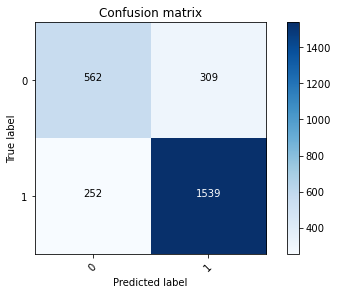

In [79]:
cnf_matrix = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [80]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  562
False Positives:  309
False Negatives:  252
True Positives:  1539
